In [54]:
import os
import pandas as pd

from scipy.sparse import hstack, csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import numpy as np
import matplotlib.pyplot as plt

# Sample data representation, replace with actual CSV reading
train_data = pd.read_csv(r"D:\\BHUVI\\GUVI\\Projects\\5\\Microsoft_Classifying_Cybersecurity_Incidents_with_Machine_Learning\\DataSet\\GUIDE_Train.csv", nrows=10000)
train_data

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,687194770257,75,394228,871699,2024-06-11T16:43:21.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
9996,730144442453,49,29149,18644,2024-06-07T06:51:11.000Z,1,1,InitialAccess,T1566.002,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
9997,154618823286,17,56608,133226,2024-06-07T23:48:32.000Z,20,29882,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
9998,120259085306,408,201579,1372581,2024-06-05T18:43:59.000Z,81,12372,SuspiciousActivity,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [55]:
train_data['Category'].unique()

array(['InitialAccess', 'Exfiltration', 'CommandAndControl', 'Execution',
       'SuspiciousActivity', 'Impact', 'Collection', 'CredentialAccess',
       'Persistence', 'Discovery', 'Malware', 'DefenseEvasion', 'Exploit',
       'PrivilegeEscalation', 'LateralMovement', 'Ransomware',
       'UnwantedSoftware'], dtype=object)

In [56]:
train_data['EvidenceRole'].unique()

array(['Related', 'Impacted'], dtype=object)

In [57]:
train_data['CountryCode'].unique()

array([ 31, 242,   8,   7,  39,  12,  33,   2,  41,   3,   0,   1,   4,
        17,  23,  47,  42,  59,  46,  21,  16,   5,   9,  34,   6,  11,
        62,  57,  14,  37,  13,  29,  15,  32,  26,  19,  25,  51,  50,
        60,  67,  24,  65,  38,  43,  20,  75,  27, 140,  18,  58,  10,
        35,  64,  40,  70,  30,  36,  55,  45,  63,  52,  44,  22,  28,
        61,  68,  89])

In [58]:
train_data.iloc[:,:15].head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,NaN,NaN,Ip,Related,98799
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,NaN,NaN,User,Impacted,98799
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,NaN,NaN,Url,Related,98799
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,NaN,NaN,Url,Related,98799
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,NaN,NaN,User,Impacted,98799


In [59]:
train_data.iloc[:, [0, 9] + list(range(15, 30))].head()

,Id,IncidentGrade,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName
0,180388628218,TruePositive,138268,27,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421
1,455266534868,FalsePositive,138268,360606,160396,22406,23032,22795,24887,153085,529644,NaN,1631,635,860,2251,3421
2,1056561957389,FalsePositive,138268,360606,68652,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421
3,1279900258736,BenignPositive,138268,360606,13,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421
4,214748368522,TruePositive,138268,360606,160396,449,592,440,479,153085,529644,NaN,1631,635,860,2251,3421


In [60]:
train_data.iloc[:, [0, 9] + list(range(30, 45))].head()

,Id,IncidentGrade,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,TruePositive,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,FalsePositive,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,FalsePositive,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,BenignPositive,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,TruePositive,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [61]:
train_data['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    4391
TruePositive      3446
FalsePositive     2110
Name: count, dtype: int64

In [62]:
train_data['IncidentGrade'].value_counts() * 100 / train_data['IncidentGrade'].shape[0]

IncidentGrade
BenignPositive    43.91
TruePositive      34.46
FalsePositive     21.10
Name: count, dtype: float64

In [63]:
train_data.isnull().sum()

Id                       0
OrgId                    0
IncidentId               0
AlertId                  0
Timestamp                0
DetectorId               0
AlertTitle               0
Category                 0
MitreTechniques       5799
IncidentGrade           53
ActionGrouped         9941
ActionGranular        9941
EntityType               0
EvidenceRole             0
DeviceId                 0
Sha256                   0
IpAddress                0
Url                      0
AccountSid               0
AccountUpn               0
AccountObjectId          0
AccountName              0
DeviceName               0
NetworkMessageId         0
EmailClusterId        9881
RegistryKey              0
RegistryValueName        0
RegistryValueData        0
ApplicationId            0
ApplicationName          0
OAuthApplicationId       0
ThreatFamily          9923
FileName                 0
FolderPath               0
ResourceIdName           0
ResourceType          9992
Roles                 9789
O

In [64]:
# def prepare_data():

le_cat_columns = ['Category', 'EntityType', 'EvidenceRole', 'SuspicionLevel', 'LastVerdict',
                  'ResourceType', 'Roles', 'AntispamDirection', 'ThreatFamily','CountryCode',
                  'OSFamily', 'OSVersion','State', 'City', 'RegistryValueName', 'RegistryValueData', 
                  'ResourceIdName', 'RegistryKey', 'OAuthApplicationId', 'ApplicationId', 'ApplicationName']

numerical_columns = ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
                     'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'FileName', 'FolderPath']

le_cat_columns += numerical_columns

numerical_columns = []

ohe_cat_columns = []

In [65]:
train_data[le_cat_columns].nunique().sort_values(ascending=False)

AccountUpn            3386
AccountName           2323
AccountSid            2211
AccountObjectId       2200
IpAddress             1879
NetworkMessageId      1193
FileName               706
DeviceName             686
Url                    603
Sha256                 512
FolderPath             465
DeviceId               375
City                   196
State                  136
EmailClusterId         114
CountryCode             68
ThreatFamily            59
ApplicationName         23
ApplicationId           21
EntityType              20
Category                17
ResourceIdName          12
RegistryKey             10
Roles                    6
OSVersion                6
ResourceType             5
RegistryValueName        5
RegistryValueData        4
LastVerdict              3
OSFamily                 3
OAuthApplicationId       3
EvidenceRole             2
AntispamDirection        2
SuspicionLevel           2
dtype: int64

In [66]:
train_data[numerical_columns].nunique().sort_values(ascending=False)

Series([], dtype: float64)

In [67]:
# Inspect columns with number of unique values less than 10
for col in train_data:
    if train_data[col].nunique() < 10:
        print(col, train_data[col].unique())

IncidentGrade ['TruePositive' 'FalsePositive' 'BenignPositive' nan]
ActionGrouped [nan 'ContainAccount' 'IsolateDevice']
ActionGranular [nan 'account password changed'
 'update stsrefreshtokenvalidfrom timestamp.' 'account disabled'
 'disable account.' 'isolateresponse' 'reset user password.'
 'change user password.' 'quarantinefile'
 'msecidentitiesconfirmusercompromised']
EvidenceRole ['Related' 'Impacted']
RegistryValueName [635   0  28  10  89]
RegistryValueData [860  25  94   0]
OAuthApplicationId [881   2   0]
ResourceType [nan 'Virtual Machine' 'API Management Service' 'Networking'
 'Azure Resource' 'Azure Arc machine']
Roles [nan 'Contextual' 'Destination' 'Attacker' 'Compromised' 'Suspicious'
 'Source']
OSFamily [5 0 2]
OSVersion [66  0  1  3 16  4]
AntispamDirection [nan 'Inbound' 'Intraorg']
SuspicionLevel [nan 'Suspicious' 'Incriminated']
LastVerdict [nan 'Suspicious' 'Malicious' 'NoThreatsFound']


In [68]:
def preprocess_data(df, le_cat_columns):
    """
        This function preprocesses the dataset
    """
    
    # Converts columns with fewer than 20 unique values to ohe categorical columns
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Converts numerical to label encoded categorical columns
    for le_col in le_cat_columns:
        df[le_col] = df[le_col].astype('object')

    return df

In [69]:
train_data = preprocess_data(train_data, le_cat_columns)

In [70]:
print(train_data[le_cat_columns].nunique())
print(train_data[ohe_cat_columns].nunique())
print(train_data[numerical_columns].nunique())

Category                17
EntityType              20
EvidenceRole             2
SuspicionLevel           2
LastVerdict              3
ResourceType             5
Roles                    6
AntispamDirection        2
ThreatFamily            59
CountryCode             68
OSFamily                 3
OSVersion                6
State                  136
City                   196
RegistryValueName        5
RegistryValueData        4
ResourceIdName          12
RegistryKey             10
OAuthApplicationId       3
ApplicationId           21
ApplicationName         23
DeviceId               375
Sha256                 512
IpAddress             1879
Url                    603
AccountSid            2211
AccountUpn            3386
AccountObjectId       2200
AccountName           2323
DeviceName             686
NetworkMessageId      1193
EmailClusterId         114
FileName               706
FolderPath             465
dtype: int64
Series([], dtype: float64)
Series([], dtype: float64)


In [71]:
from sklearn.feature_selection import f_classif

cat_columns = ohe_cat_columns + le_cat_columns

# stats_data = pd.DataFrame()

for cat in cat_columns:
    # One-Hot Encode the categorical data
    onehot_encoder = OneHotEncoder(sparse_output=False)  # Adjust for the FutureWarning
    X_encoded = onehot_encoder.fit_transform(train_data[[cat]])  # Use double brackets to pass a 2D array
    
    # ANOVA F-Statistic
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(train_data['IncidentGrade'])  # Assuming IncidentGrade is categorical
    f_statistic, p_value = f_classif(X_encoded, y)
    
    print("*" * 20)
    print(f"Feature: {cat}")
    print(f"ANOVA F-Statistic: {f_statistic}")
    print(f"p-Value: {p_value}")

********************
Feature: Category
ANOVA F-Statistic: [  7.00254755  92.58639546   3.09948296   6.49285618   9.79556804
  11.838447   299.46458326   0.61664621   7.26672376 546.64932359
  10.88150204   7.96114589  17.81756912   1.70405179  10.34171089
  15.17589261   1.04381464]
p-Value: [1.05950479e-004 4.24174750e-059 2.56200184e-002 2.19538767e-004
 1.89503308e-006 9.76713575e-008 3.55756337e-186 6.04145409e-001
 7.25665378e-005 0.00000000e+000 3.92457716e-007 2.67683745e-005
 1.57225136e-011 1.63840000e-001 8.58899200e-007 7.50932599e-010
 3.71848977e-001]
********************
Feature: EntityType
ANOVA F-Statistic: [  1.2465377    2.15773925   4.56910177 276.71322975  61.30340991
  57.40804916   0.85163764  68.85139816  71.39049445   2.75570284
 109.33946921   4.88714971   0.64581447   2.49425806  24.32592096
   9.3422696    5.10165539   1.2465377   33.63333252  77.87348648]
p-Value: [2.91049643e-001 9.07954176e-002 3.34548278e-003 1.50364845e-172
 2.88396644e-039 8.69618565e-0

In [53]:
# Convert 'Timestamp' column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Uid                 10000 non-null  int64              
 1   Id                  10000 non-null  int64              
 2   OrgId               10000 non-null  int64              
 3   IncidentId          10000 non-null  int64              
 4   AlertId             10000 non-null  int64              
 5   Timestamp           10000 non-null  datetime64[ns, UTC]
 6   DetectorId          10000 non-null  int64              
 7   AlertTitle          10000 non-null  int64              
 8   Category            10000 non-null  object             
 9   MitreTechniques     4213 non-null   object             
 10  IncidentGrade       9949 non-null   object             
 11  ActionGrouped       56 non-null     object             
 12  ActionGranular      56 non-null  

In [72]:
def process_data():
    train_data = pd.read_csv(r'D:\\BHUVI\\GUVI\\Projects\\5\\Microsoft_Classifying_Cybersecurity_Incidents_with_Machine_Learning\\DataSet\\GUIDE_Train.csv') 
    test_data = pd.read_csv(r'D:\\BHUVI\\GUVI\\Projects\\5\\Microsoft_Classifying_Cybersecurity_Incidents_with_Machine_Learning\\DataSet\\GUIDE_Test.csv')
    
    print(train_data.shape)
    
    # Drop rows with missing target variable 'IncidentGrade'
    train_data.dropna(subset=['IncidentGrade'], inplace=True)
    
    train_data = preprocess_data(train_data, le_cat_columns)
    test_data = preprocess_data(test_data, le_cat_columns)
    
    group_columns = ohe_cat_columns + numerical_columns + le_cat_columns
    
    # Drop duplicates based on the specified columns
    train_data = train_data.drop_duplicates(subset=group_columns)
    
    # Drop usage column as it is not present in train dataset
    test_data.drop(['Usage'], axis=1, inplace=True)
    
    print(train_data.shape)
    print(test_data.shape)
    
    #  One hot encoding
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(train_data[ohe_cat_columns])

    train_data_ohe = csr_matrix(ohe.transform(train_data[ohe_cat_columns]))
    test_data_ohe = csr_matrix(ohe.transform(test_data[ohe_cat_columns]))

    # Fill NaNs for numerical columns
    train_data_numerical = csr_matrix(train_data[numerical_columns].fillna(-1).values)
    test_data_numerical = csr_matrix(test_data[numerical_columns].fillna(-1).values)
    
    # Feature label encoding
    feature_le = LabelEncoder()
    
    train_data_le = pd.DataFrame()
    test_data_le = pd.DataFrame()
    
    # Fit and transform the feature variables
    for le_col in le_cat_columns:
        # we want to stack train and test for label encoding of some cat variables
        feature_le.fit(pd.concat([train_data[le_col], test_data[le_col]]))
        train_data_le[le_col] = feature_le.transform(train_data[le_col])
        test_data_le[le_col] = feature_le.transform(test_data[le_col])
    
    train_data_le = csr_matrix(train_data_le)
    test_data_le = csr_matrix(test_data_le)
    
    X_train = hstack([train_data_ohe, train_data_le ,train_data_numerical])
    X_test = hstack([test_data_ohe, test_data_le, test_data_numerical])

    # Target label encoding
    target_le = LabelEncoder()
    
    # Fit and transform the target variable
    target_le.fit(train_data['IncidentGrade'])
    y_train = target_le.transform(train_data['IncidentGrade'])
    y_test = target_le.transform(test_data['IncidentGrade'])
    
    # Print out the label classes of the target variable
    """
        0: 'BenignPositive'
        1: 'FalsePositive'
        2: 'TruePositive'
    """
    print(f"Target Classes: {target_le.classes_}")
        
    return X_train, y_train, X_test, y_test
    
    
# get the data
X_train, y_train, X_test, y_test = process_data()

C:\Users\lokesh\AppData\Local\Temp\ipykernel_7088\1444666799.py:3: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv(r'D:\\BHUVI\\GUVI\\Projects\\5\\Microsoft_Classifying_Cybersecurity_Incidents_with_Machine_Learning\\DataSet\\GUIDE_Test.csv')


(9516837, 45)
(2489784, 45)
(4147992, 45)
Target Classes: ['BenignPositive' 'FalsePositive' 'TruePositive']


In [74]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def predict(model, X_test, y_test):
    # Generate predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    # Print accuracy
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    
    cm = confusion_matrix(y_test, y_pred)
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['BenignPositive', 'FalsePositive', 'TruePositive'])

    cm_display.plot()
    plt.show()

    return y_pred

In [75]:
def train_random_forest_classifier(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
    
    model.fit(X_train, y_train)
    
    # Feature importance
    importances = model.feature_importances_
    
    feature_columns = np.array(ohe_cat_columns + le_cat_columns + numerical_columns)
    
    # Plot feature importance
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances (Random Forest Classifier)")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_columns[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    return model

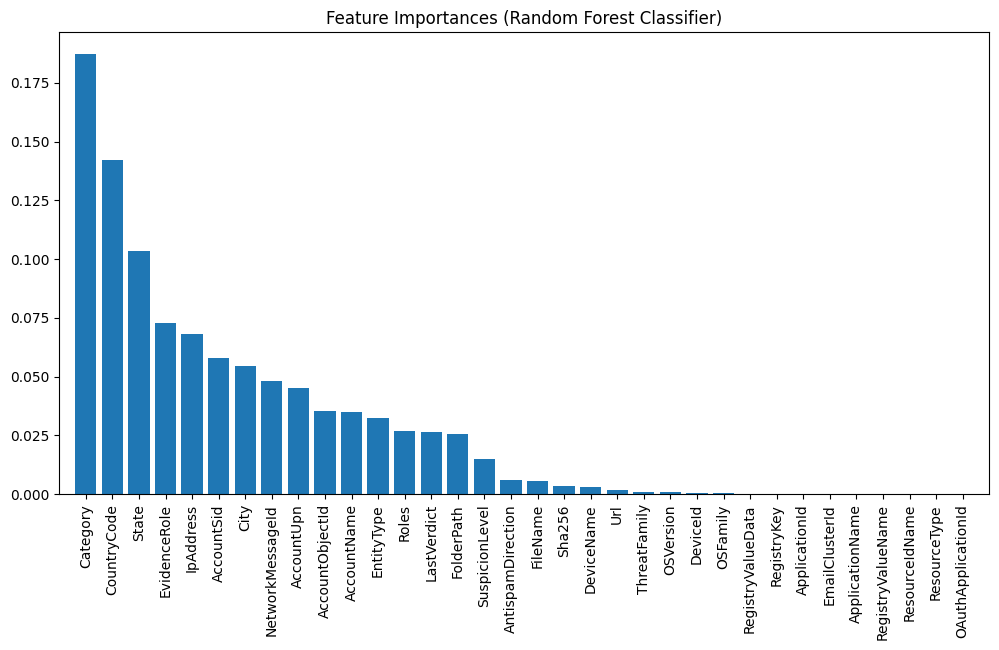

In [76]:
# train a random forest classifier model
rfc_model = train_random_forest_classifier(X_train, y_train)

Accuracy: 0.4987

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.99      0.63   1752940
           1       0.64      0.06      0.10    902698
           2       0.94      0.18      0.31   1492354

    accuracy                           0.50   4147992
   macro avg       0.68      0.41      0.35   4147992
weighted avg       0.67      0.50      0.40   4147992


Confusion Matrix:


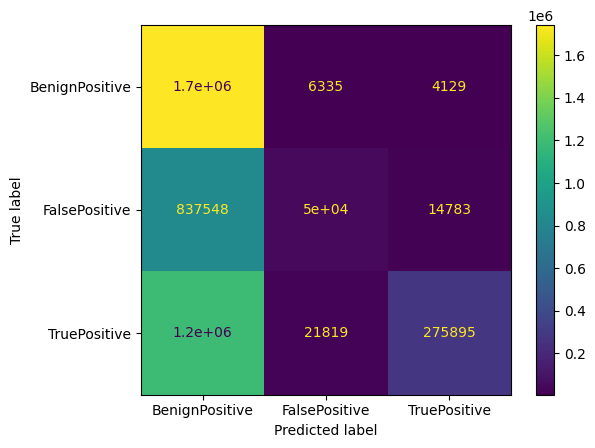

Accuracy: 0.49873239871243724
Macro-Precision: 0.6796399756953511
Macro-Recall: 0.4115663417201833
Macro-F1 Score: 0.3472925853310953


In [77]:
# make predictions
y_pred = predict(rfc_model, X_test, y_test)

# evaluate test performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))